This notebook compares the performance of `wcosmo` with that of `astropy` in calculating a few basic cosmological quantities as a function of redshift: luminosity distance ($D_L$), differential comoving volume ($\frac{dV_c}{dz}$), and the jacobian between luminosity distance and redshift ($\frac{dD_L}{dz}$). This is mainly to demonstrate the accuracy of `wcosmo` for common tasks.

We do these comparisons by overplotting each cosmological quanitity as a function of redshift for both `wcosmo` and `astropy` and show that they agree well for various values of $w$, $\Omega_m$, and $H_0$. We additionally show the fractional error between `wcosmo` and `astropy`, showing that it generally decreases with increasing redshift and increasing $\Omega_m$. All fractional errors below 0.1%, and often several orders of magnidute lower than this, indicating that the approximant used in `wcosmo` is acceptably accurate for a large portion of parameter space.

Towards the end, we will compare `wcosmo` and `astropy` with Adachi & Kasai 2011 (AK11), which provided a similar approximant to these quanities for the case when $w=-1$, and was the inspiration for this work. 

AK11 give an analytical approximation to the relationship between luminosity distance and redshift, vastly speeding up its evaluation. The exact form of the relationship when dark energy is a cosmological constant ($w=-1$) is:
\begin{equation}
d_L(z, \Omega_m) = \frac{c (1 + z)}{H_0} \int^1_{\frac{1}{1+z}} d a \sqrt{\Omega_m + (1 − \Omega_m) a^4} .
\tag{1}
\end{equation}

AK11 construct an approximation to this relationship by deriving a Taylor expansion for
\begin{equation}
F = \int^a_0 \frac{\sqrt{\Omega_m} d a'}{\sqrt{\Omega_m a' + (1 − \Omega_m)a'^4}} ,
\tag{2}
\end{equation}
which is a transformed version of the integral in Equation 1. They then approximate the frist 6 terms of this Taylor expansion with a Pade ratio. 

`wcosmo` builds on this by generalizing both the Taylor expansion and the Pade approximation for the case where $w\neq1$. We get the following Taylor expansion
\begin{equation}
F = \sqrt{a} \sum_{n=0}^{\infty}{-1/2 \choose n} \frac{x^n}{1/2-3wn}.
\tag{3}
\end{equation}
We then use a Pade approximation on the first 17 terms to calculate $d_L(z)$.

Though the methodologies are the same, we show that `wcosmo` is more accurate in practice since it uses more Taylor expansion terms for the Pade approximation.

In [1]:
from astropy.cosmology import FlatwCDM
import wcosmo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define some constants we will use throughout
Clight = wcosmo.utils.SPEED_OF_LIGHT_KM_PER_S*1e3 # convert to m/s
z_arr = np.linspace(0.0001,5,num=100)
H0_vals = [50,70,90]
Om_vals = [0.1,0.3,0.5,0.9]
colors = ['blue','orange','purple',"green"]
w_vals = [-2,-3/2,-1,-1/2,-1/3,0]

# Comparisons between `astropy.cosmology` and `wcosmo`
Let's start by determining how accurate `wcosmo` is for $H_0\in [30,90] \text{km/s/kpc}$, $\Omega_m \in [0.1,0.9]$, and $w\in[-2,0]$.

We define two plotting functions that we will use for this whole section.

In [3]:
def absolute_comparison(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, linestyles=["--","solid"], z_arr=z_arr):
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        axes[0].plot(z_arr,wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr),ls=linestyles[0],lw=3,c=c)
        axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr), color=c,ls=linestyles[1],label=f"$H_0=${H0} km/s/kpc")
    axes[0].set_ylabel(" ".join(func.title().split("_")))

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        axes[1].plot(z_arr,wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr),ls=linestyles[0],lw=3,c=c)
        axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr),color=c,ls=linestyles[1],label=f"$\Omega_m=${Om}")

    for i in [0,1]:
        axes[i].plot([],c='k',ls=linestyles[1],label="astropy")
        axes[i].plot([],c='k',ls=linestyles[0],lw=3,label="wcosmo")
        axes[i].legend(ncol=2)
        axes[i].set_xlabel("z")
        axes[i].set_ylim(bottom=0)
        axes[i].set_xlim(left=0)
    return fig


def fractional_comparison(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, z_arr=z_arr,logscaley=True):
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=False,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        ap = FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr).value
        fracerr = np.abs(wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr)-ap)/ap
        axes[0].plot(z_arr,fracerr, c=c,label=f"$H_0=${H0} km/s/kpc")
    title = " ".join(func.split("_"))
    axes[0].set_ylabel("$\\frac{\\Delta \\text{%s}}{\\text{astropy %s}}$"%(title,title))

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        ap = FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr).value
        fracerr = np.abs(wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr)-ap)/ap
        axes[1].plot(z_arr,fracerr, c=c,label=f"$\Omega_m=${Om}")
    for i in [0,1]:
        axes[i].legend()
        axes[i].set_xlabel("z")
        axes[i].set_xlim(left=0)
        if logscaley:
            axes[i].set_yscale("log")
        else:
            axes[i].set_ylim(bottom=0)
    return fig

## $w=-1$
### luminosity distance

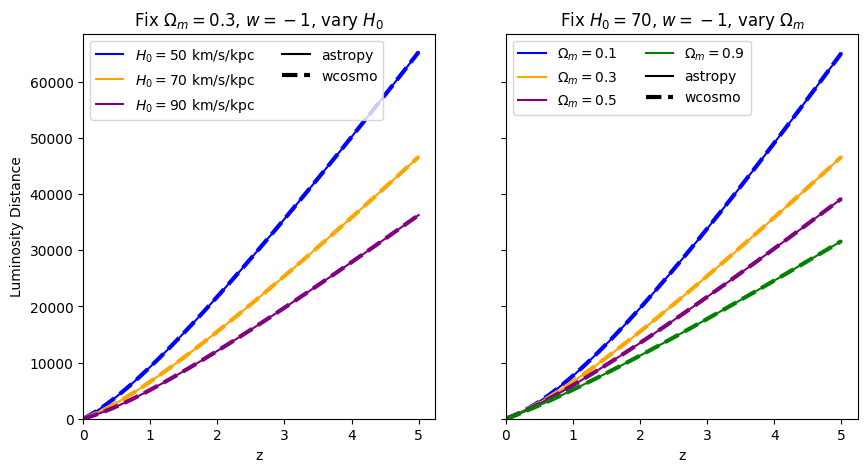

In [4]:
# luminosity distance
absolute_comparison("luminosity_distance");

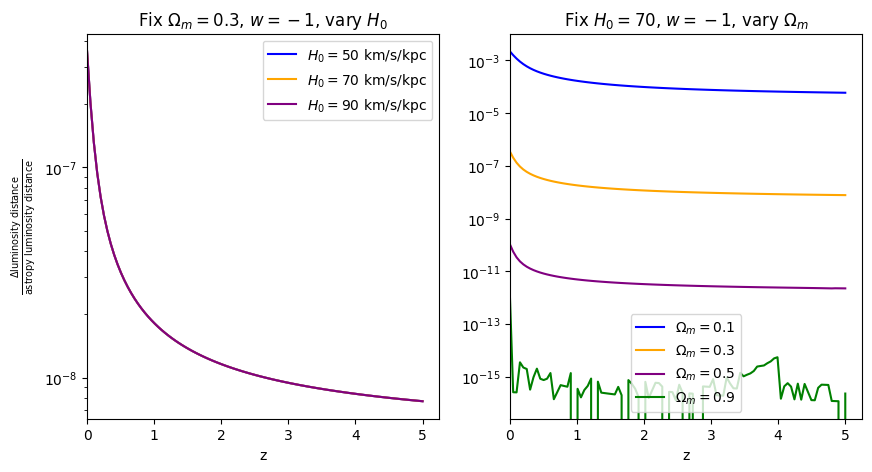

In [5]:
fractional_comparison("luminosity_distance");

When $\Omega_m=0.9$, the fractional error is comparable to floating point precision, which is why it looks a bit jaggedy.

### $\frac{dV_c}{dz}$: differential comoving volume

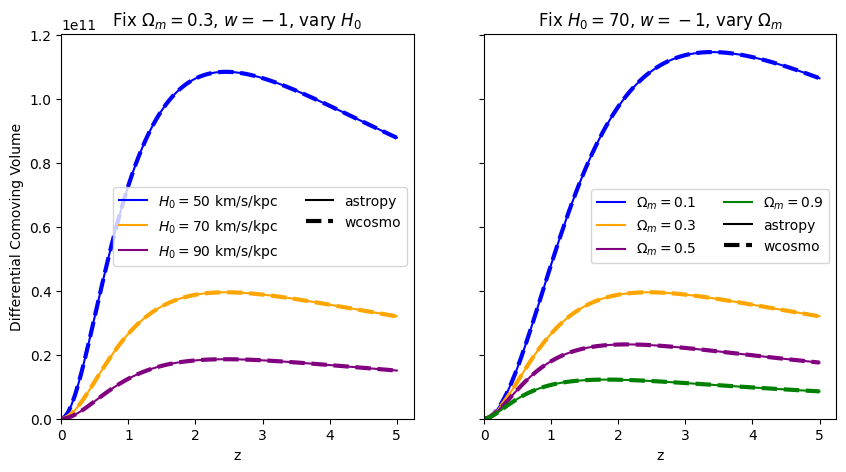

In [6]:
absolute_comparison("differential_comoving_volume");

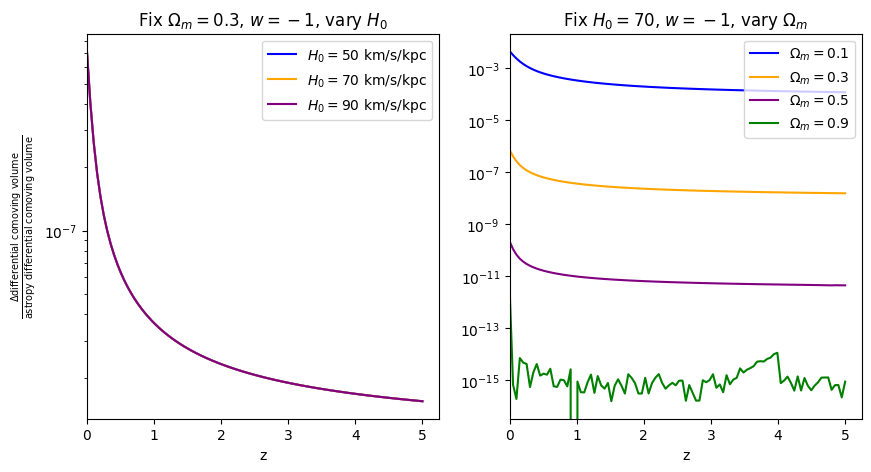

In [7]:
# fractional error in diff comov. vol
fractional_comparison("differential_comoving_volume");

### $\frac{d D_L}{dz}$: Jacobian between luminosity distance and redshift
Used commonly in GW data analysis

Text(0, 0.5, '$\\frac{dD_L}{dz} [Mpc]$')

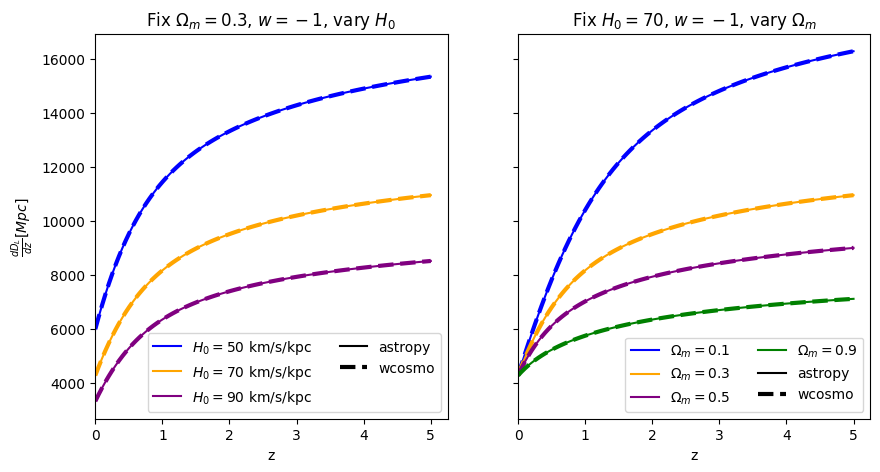

In [8]:
# Jacobian factor: ddL/dz

def dDL_dz(astropycosmo,z):
    dL = astropycosmo.luminosity_distance(z).value
    Ez_i = astropycosmo.inv_efunc(z)
    D_H = (Clight/1e3) / astropycosmo.H0.value
    return np.abs(dL/(1.+z) + (1.+z)*D_H * Ez_i)

fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,wcosmo.FlatLambdaCDM(H0=H0,Om0=0.3).dDLdz(z_arr),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,dDL_dz(FlatwCDM(H0=H0,Om0=0.3),z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="wcosmo")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,wcosmo.FlatLambdaCDM(H0=70,Om0=Om).dDLdz(z_arr),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,dDL_dz(FlatwCDM(H0=70,Om0=Om),z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="wcosmo")
axes[1].legend(ncol=2)

for i in [0,1]:
    axes[i].set_xlabel("z")
    axes[i].set_xlim(left=0)
axes[0].set_ylabel("$\\frac{dD_L}{dz} [Mpc]$")

We find that the relative error is just a function of $\Omega_m$ and redshift, not $H_0$, which is expected as the approximant only changes $D_L(z)$, leaving $H_0$ as a constant factor common to both `wcosmo` and `astropy`'s calculations. 

## $w\neq-1$

This is where `wcosmo` differs from A&K2011. Let's compare what we get with `astropy`, for various values of $w$.

### Luminosity distance

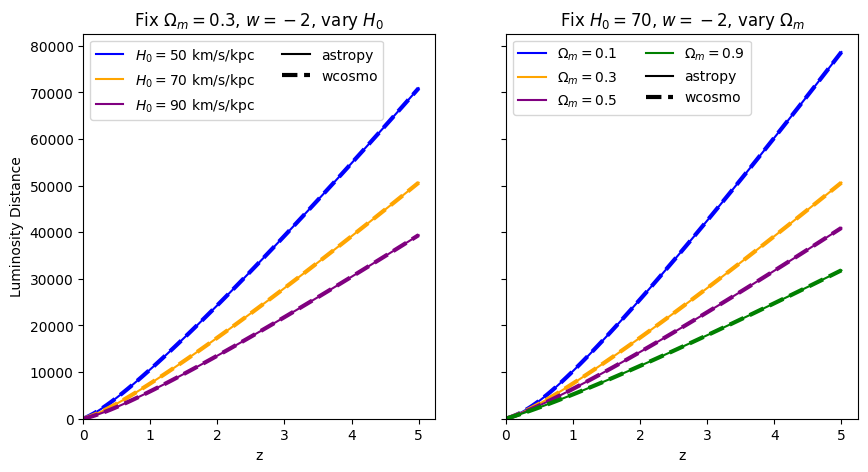

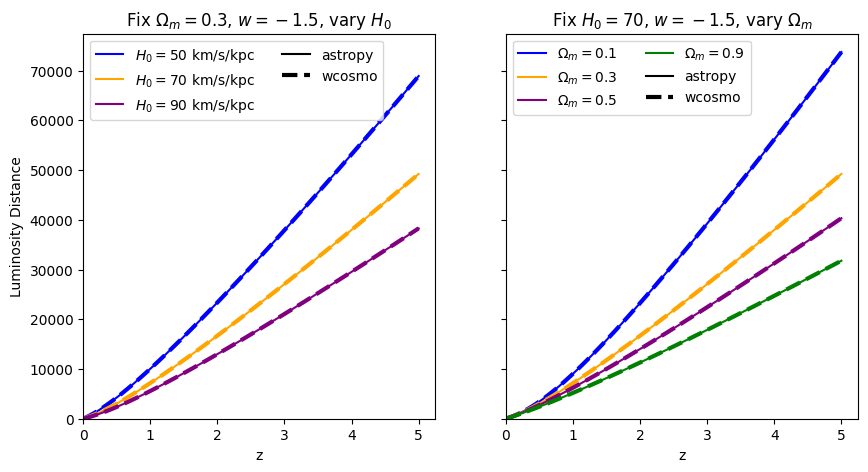

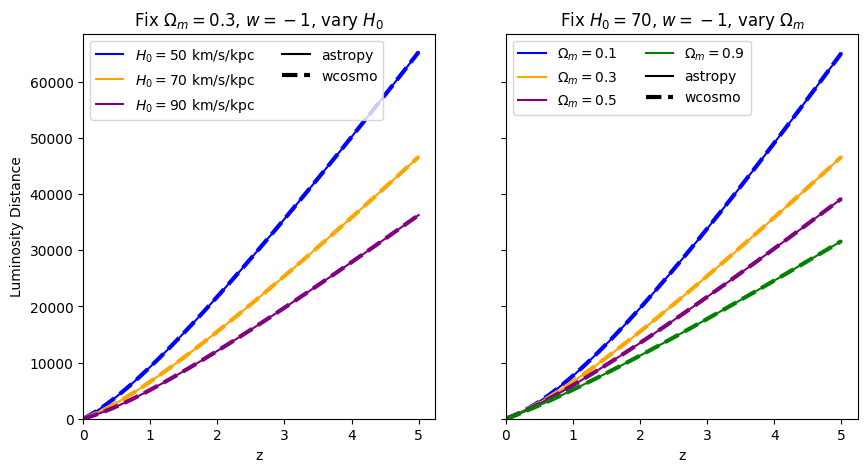

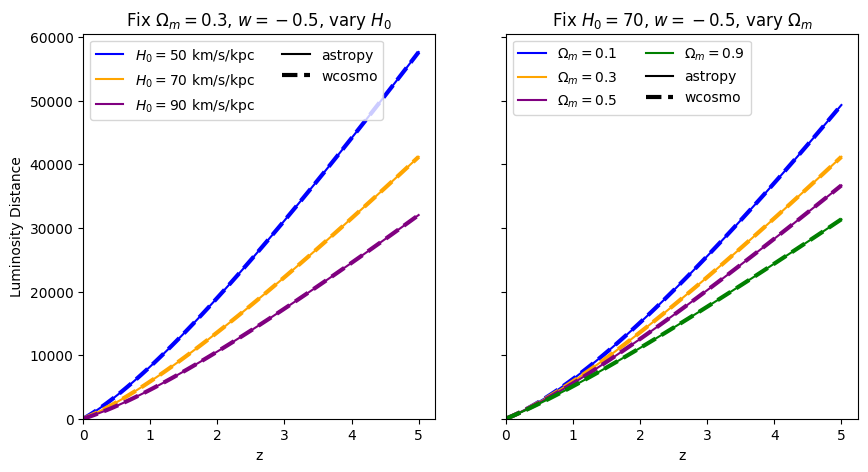

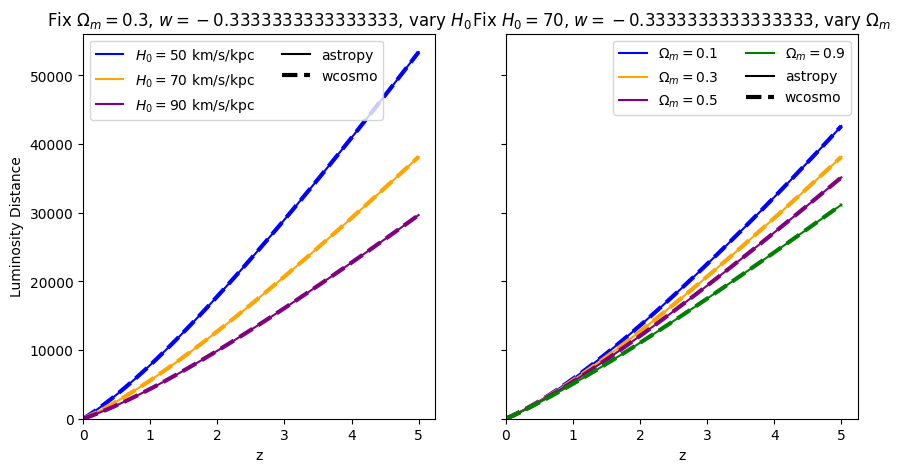

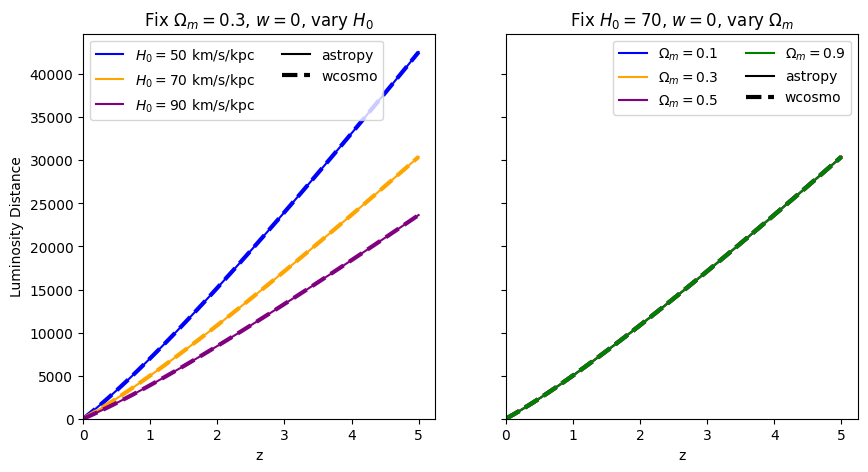

In [9]:
for w in w_vals:
    absolute_comparison("luminosity_distance",w=w)

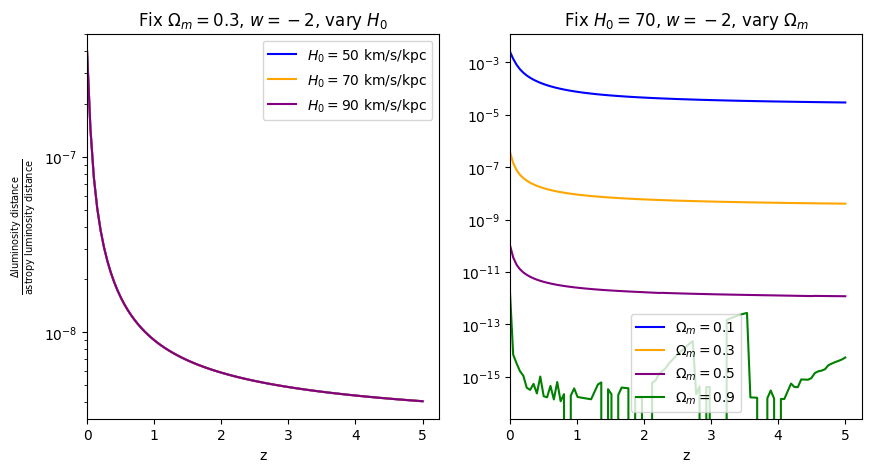

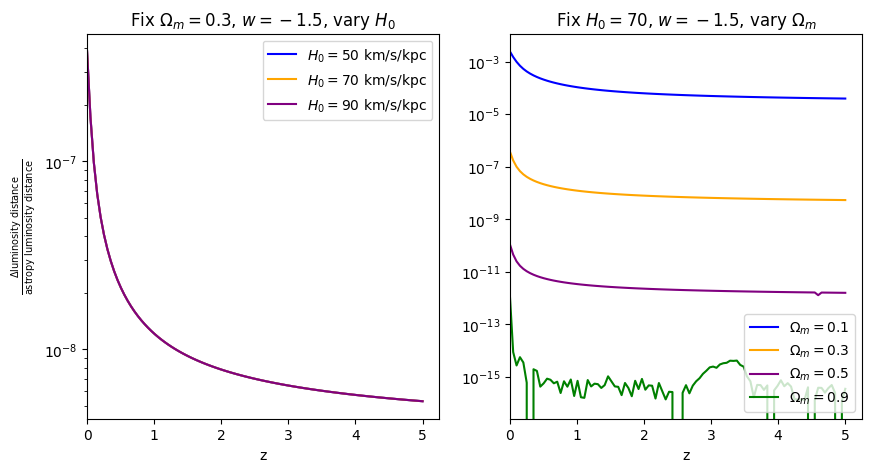

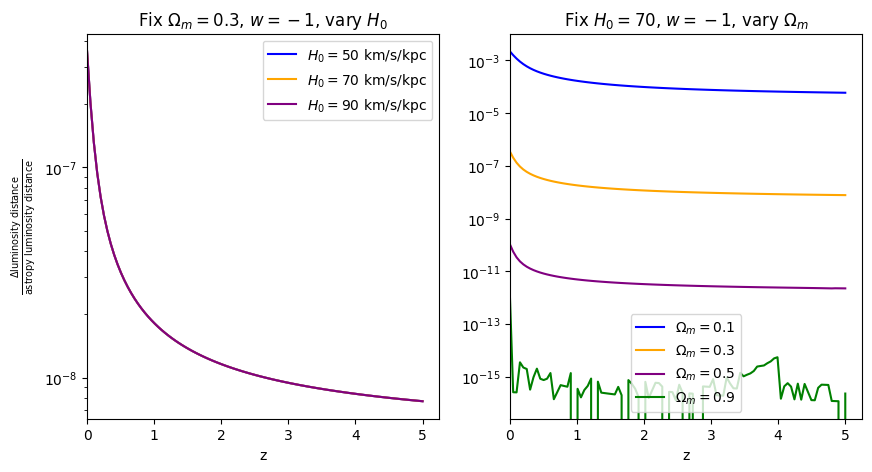

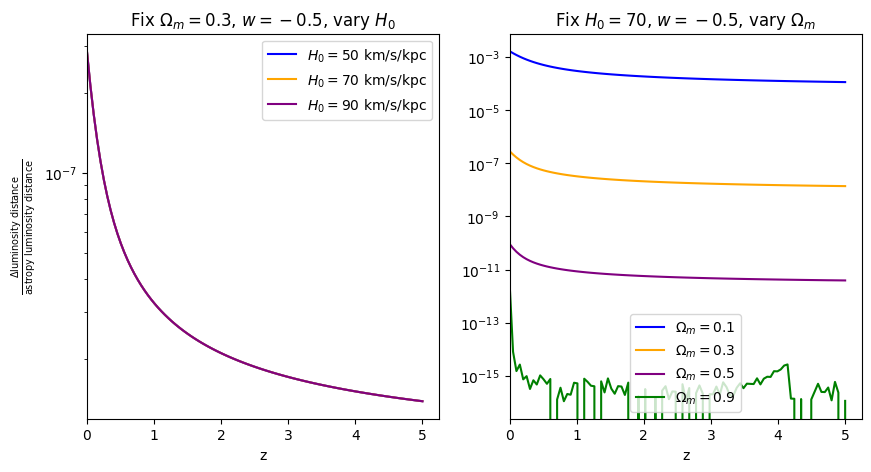

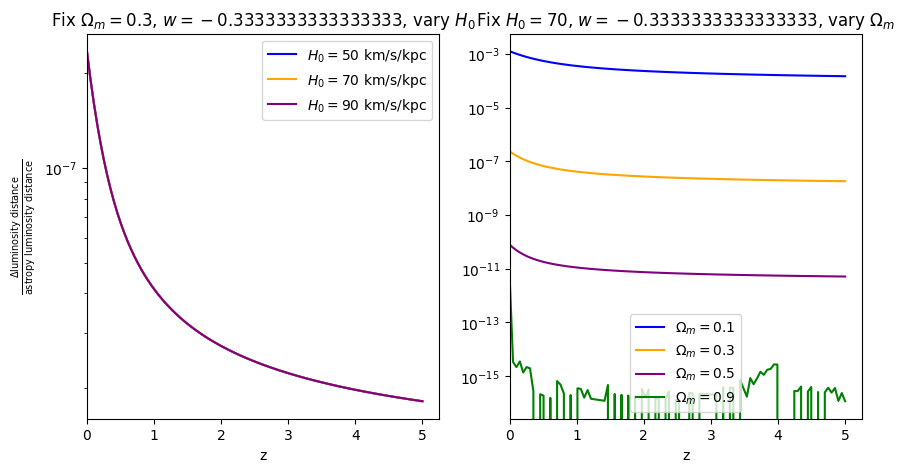

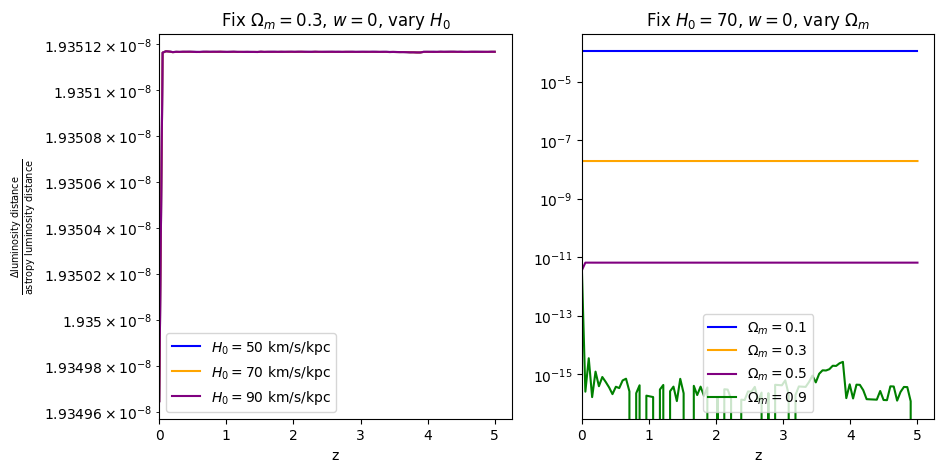

In [10]:
for w in w_vals:
    fractional_comparison("luminosity_distance",w=w)

### $\frac{dV_c}{dz}$: differential comoving volume

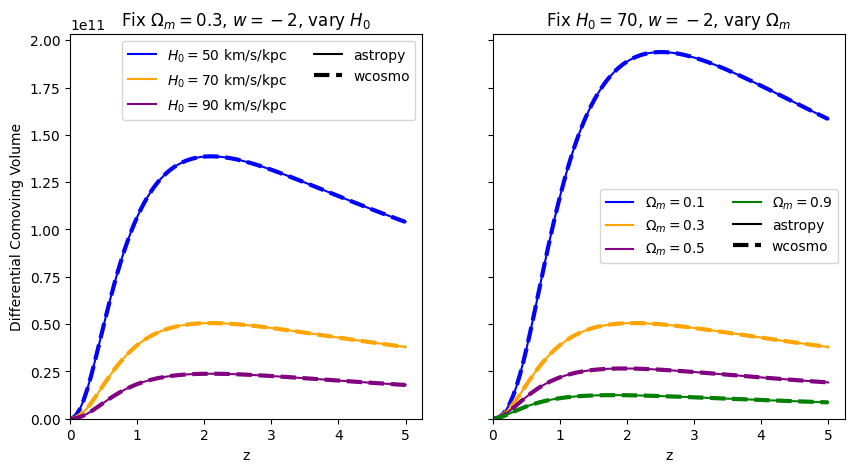

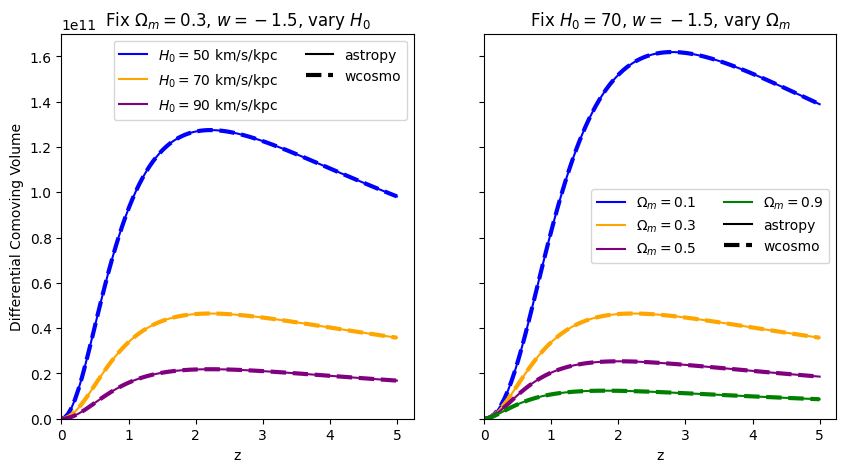

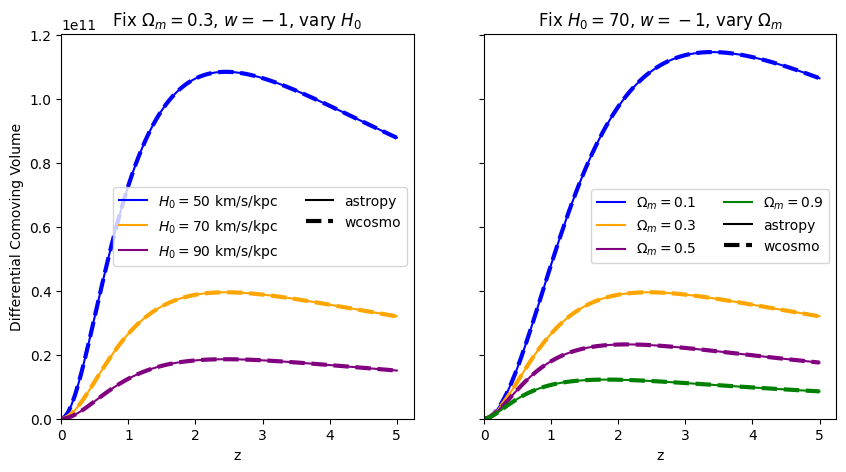

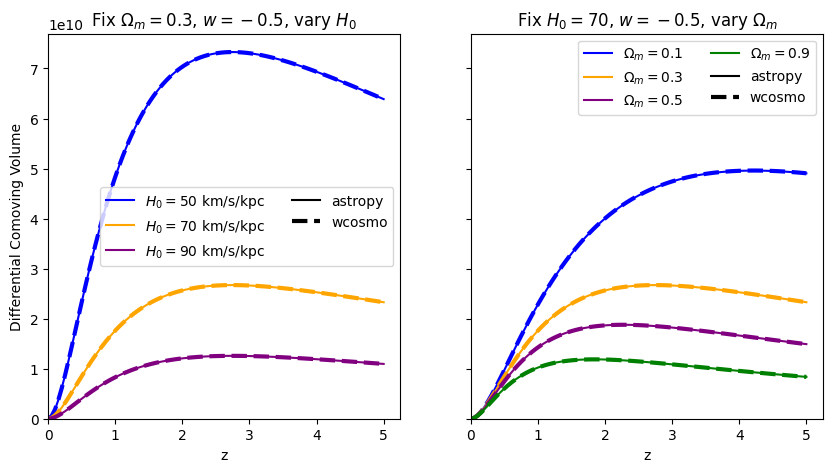

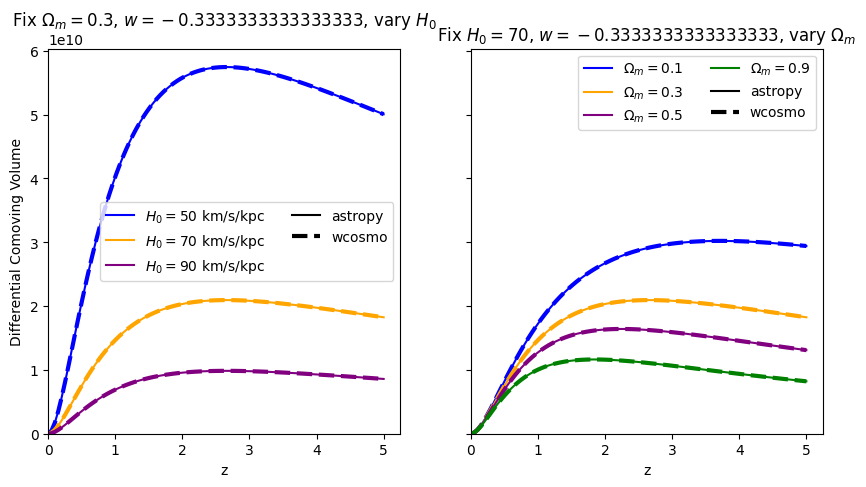

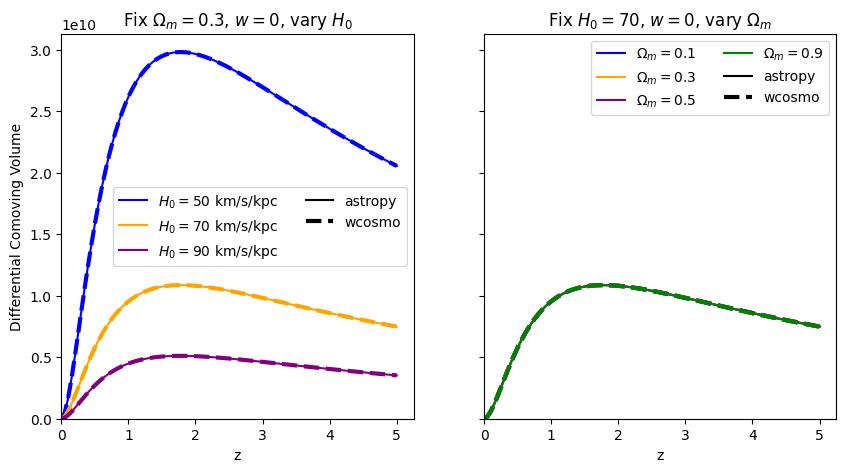

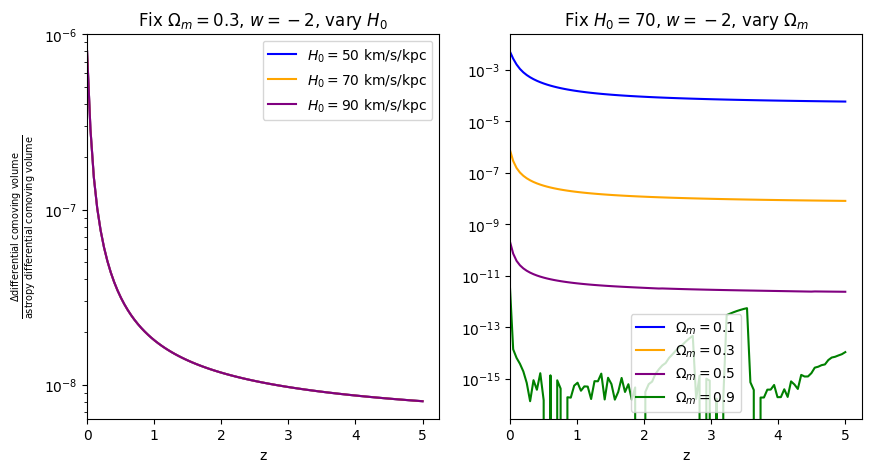

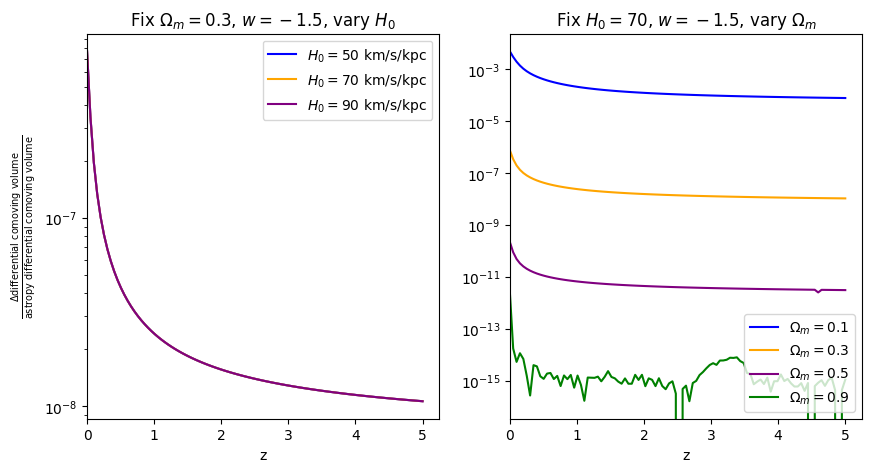

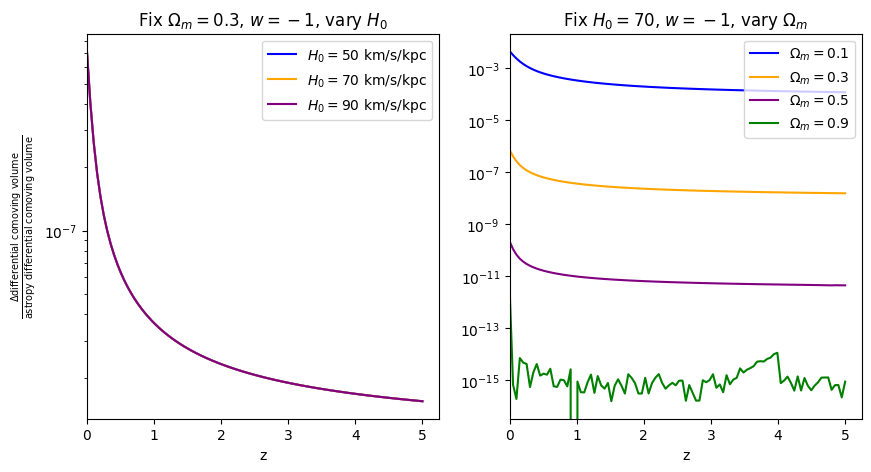

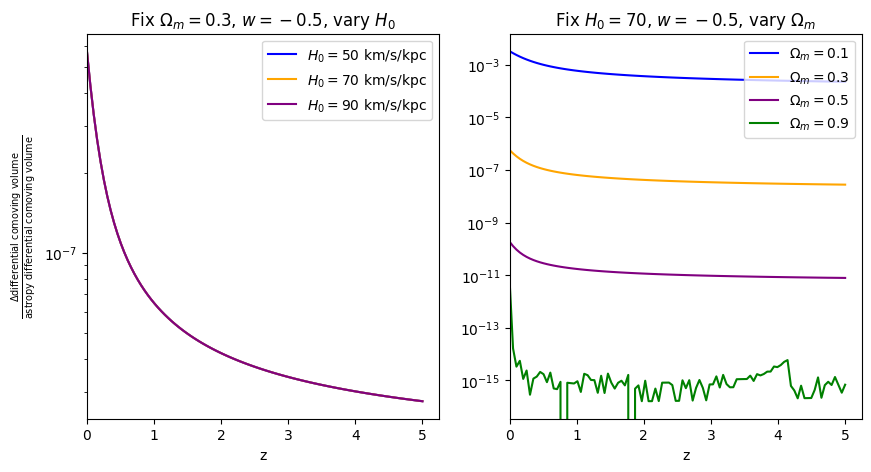

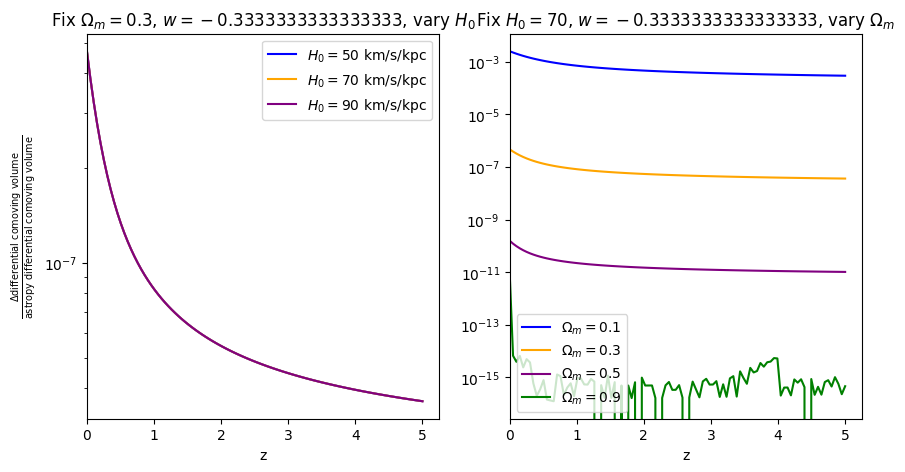

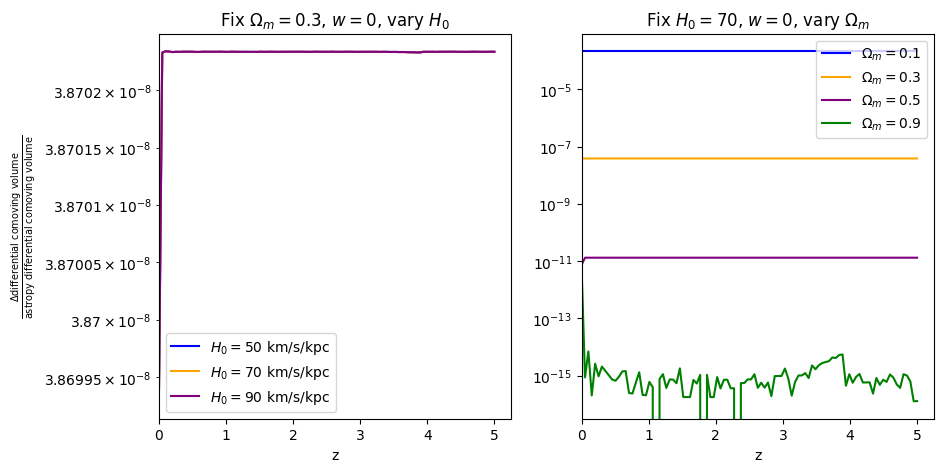

In [11]:
for w in w_vals:
    f=absolute_comparison("differential_comoving_volume",w=w)
for w in w_vals:
    f=fractional_comparison("differential_comoving_volume",w=w)


# Comparisons between Adachi & Kasai 2011, `astropy`, and `wcosmo`
Now that we understand where in parameter space `wcosmo` is most accurate, let's compare it's accuracy with the Adachi & Kasai 2011 (AK11) approximation in those same regions. We start by writing down their approximation. 

In [12]:
# Adachi and Kasai functions
def Phi(x):
    num = 1 + 1.320*x + 0.4415* np.power(x,2) + 0.02656*np.power(x,3)
    den = 1 + 1.392*x + 0.5121* np.power(x,2) + 0.03944*np.power(x,3)
    return num/den
def xx(z,Om0):
    return (1.0-Om0)/Om0/np.power(1.0+z,3)
def Ez_inv(z,Om0):
    return 1./np.sqrt((1.-Om0) + Om0*np.power((1.+z),3))

def dL_approx(z,H0,Om0,w=-1): # add "w" so passing w doesn't throw and error but also does nothing
    if w != -1:
        print("Warning! w != -1 was passed but has no effect")
    D_H = (Clight/1.0e3)  / H0 #Mpc
    return 2.*D_H * (1.+z) * (Phi(xx(0.,Om0)) - Phi(xx(z,Om0))/np.sqrt(1.+z))/np.sqrt(Om0)

def dDLdz_approx(z, H0, Om0,w=-1):
    if w != -1:
        print("Warning! w != -1 was passed but has no effect")
    dL = dL_approx(z,H0,Om0)#Mpc
    Ez_i = Ez_inv(z,Om0)
    D_H = (Clight/1e3) / H0 #Mpc
    return np.abs(dL/(1.+z) + (1.+z)*D_H * Ez_i)

def diff_comoving_volume_approx(z,H0,Om0,w=-1):
    if w != -1:
        print("Warning! w != -1 was passed but has no effect")
    dL = dL_approx(z,H0,Om0) #Mpc
    Ez_i = Ez_inv(z,Om0)
    D_H = (Clight/1e3)  / H0 #Mpc
    return np.power(dL,2) * D_H * Ez_i / np.power(1.+z,2.)

There are two differences between `wcosmo` and AK2011: the addition of variable $w$, and the inclusion of additional terms of the Taylor expansion. If we want to just isolate the effect of the latter, we can write down the approximation used for `wcosmo` but with the same number of terms (6) used in AK11. This is done below.

In [30]:
# with w != -1
# similar to what is implemented in wcosmo, but with the same number of terms as in Adachi & Kasai 2011
def Phi_w(x,w):
    num = 2 * (64 + 80*x + 24*x**2 + x**3 - 24 * w * (624 + 760 * x + 222*x**2 + 9*x**3) + 
    144 * w**2 * (11920 + 14560 * x + 4278*x**2 + 175*x**3) - 
    1728 * w**3 * (71672 + 87840 * x + 25791*x**2 + 1049*x**3) + 
    2592 * w**4 * (2356832 + 2882800 * x + 839268*x**2 + 33719*x**3) - 
    62208 * w**5 * (3445928 + 4201240 * x + 1212453*x**2 + 48254*x**3) + 
    313456656384 * w**12 * (3319040 + 4519200 * x + 1598688*x**2 + 
       111783*x**3) + 
    186624 * w**6 * (29448112 + 35918800 * x + 10359714*x**2 + 413179*x**3) - 
    17414258688 * w**11 * (30788544 + 38850120 * x + 11816424*x**2 + 
       495569*x**3) - 
    2239488 * w**7 * (46909544 + 57549840 * x + 16745037*x**2 + 668609*x**3) + 
    1934917632 * w**10 * (61958336 + 76676430 * x + 22483512*x**2 + 
       837203*x**3) - 
    120932352 * w**9 * (133531520 + 165267720 * x + 48520736*x**2 + 
       1828153*x**3) + 
    1679616 * w**8 * (900485632 + 1112477520 * x + 326613696*x**2 + 
       12787417*x**3))
    den = (-1 + 6 * w) * (-1 + 12 * w) * (-1 + 18 * w) * (64 + 112 * x + 56 * x**2 + 7 * x**3 - 
   12*w * (1056 + 1792 * x + 868 * x**2 + 105 * x**3) + 
   36*w**2 * (34304 + 58128 * x + 28336 * x**2 + 3479 * x**3) - 
   432*w**3 * (171968 + 288960 * x + 139552 * x**2 + 16891 * x**3) - 
   # 241864704*w**9 * (3319040 + 4519200 * x + 1598688 * x**2 + 111783 * x**3) + 
   1296*w**4 * (2260032 + 3729936 * x + 1763944 * x**2 + 209097 * x**3) - 
   3919104*w**7 * (4782720 + 7538144 * x + 3394704 * x**2 + 391167 * x**3) - 
   15552*w**5 * (5009056 + 8107680 * x + 3754156 * x**2 + 439439 * x**3) + 
   6718464*w**8 * (25067648 + 37946160 * x + 15870960 * x**2 + 1547889 * x**3) + 
   46656*w**6 * (30759808 + 49091504 * x + 22480304 * x**2 + 2667861 * x**3))
    return -1*num/den

def xx_w(z,Om0,w):
    return (1.0-Om0)/Om0/np.power(1.0+z,-3*w)

def Ez_inv_w(z,Om0,w):
    return 1./np.sqrt((1.-Om0)*np.power((1.+z),3*(1+w)) + Om0*np.power((1.+z),3))

def dL_approx_w(z,H0,Om0,w):
    D_H = (Clight/1.0e3)  / H0 #Mpc
    return D_H * (1.+z) * (Phi_w(xx_w(0.,Om0,w),w) - Phi_w(xx_w(z,Om0,w),w)/np.sqrt(1.+z))/np.sqrt(Om0)

def diff_comoving_volume_approx_w(z,H0,Om0,w):
    dL = dL_approx_w(z,H0,Om0,w) #Mpc
    Ez_i = Ez_inv_w(z,Om0,w)
    D_H = (Clight/1e3)  / H0 #Mpc
    return np.power(dL,2) * D_H * Ez_i / np.power(1.+z,2.)


In [14]:
# plotting functions
def absolute_comparison_ak(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, linestyles=["--","solid",":"], z_arr=z_arr):
    # map to AK11-like function
    # we change functions depending on the value of w so we can be sure we are making a direct comparison with AK11 when using w=-1
    if w==-1:
        func_map = dict(luminosity_distance=dL_approx,
                        differential_comoving_volume=diff_comoving_volume_approx)
    else:
        func_map = dict(luminosity_distance=dL_approx_w,
                        differential_comoving_volume=diff_comoving_volume_approx_w)
    
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        axes[0].plot(z_arr,wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr),ls=linestyles[0],alpha=0.5,lw=3,c=c)
        axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr), color=c,ls=linestyles[1],alpha=0.5,label=f"$H_0=${H0} km/s/kpc")
        axes[0].plot(z_arr,func_map[func](z_arr,H0=H0,Om0=0.3,w=w),color=c,ls=linestyles[2],alpha=0.5)
    axes[0].plot([],c='k',ls=linestyles[0],lw=3,label="wcosmo")
    axes[0].plot([],c='k',ls=linestyles[1],label="astropy")
    axes[0].plot([],c='k',ls=linestyles[2],lw=3,label="AK11")    

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        axes[1].plot(z_arr,wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr), alpha=0.5, ls=linestyles[0],lw=3,c=c)
        axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr),color=c, alpha=0.5, ls=linestyles[1],label=f"$\Omega_m=${Om}")
        axes[1].plot(z_arr,func_map[func](z_arr,H0=70,Om0=Om,w=w),color=c, alpha=0.5, ls=linestyles[2])
    axes[1].plot([],c='k',ls=linestyles[0], alpha=0.5, lw=3, label="wcosmo")
    axes[1].plot([],c='k',ls=linestyles[1], alpha=0.5, label="astropy")
    axes[1].plot([],c='k',ls=linestyles[2], alpha=0.5, lw=3, label="AK11")

    axes[0].set_ylabel(" ".join(func.title().split("_")))
    for i in [0,1]:
        axes[i].set_xlabel("z")
        axes[i].legend(ncol=2)
        axes[i].set_xlim(left=0)
        axes[i].set_ylim(bottom=0)
    return fig


def fractional_comparison_ak(func, H0_arr=H0_vals, Om_arr=Om_vals, w=-1, colors=colors, linestyles=["solid",":","-."],z_arr=z_arr,logscaley=True):
    # we do this so we can be sure we are making a direct comparison with AK11 when using w=-1
    if w==-1:
        func_map = dict(luminosity_distance=dL_approx,
                        differential_comoving_volume=diff_comoving_volume_approx)
    else:
        func_map = dict(luminosity_distance=dL_approx_w,
                        differential_comoving_volume=diff_comoving_volume_approx_w)
    
    
    fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=False,figsize=(10,5))
    # axis 0: vary H0
    axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
    for H0, c in zip(H0_arr,colors):
        ap = FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr).value
        wcos = wcosmo.FlatwCDM(H0=H0,Om0=0.3,w0=w).__getattribute__(func)(z_arr)
        ak = func_map[func](z_arr,H0=H0,Om0=0.3,w=w)
        fracerr_ap_wcosmo = np.abs(wcos-ap)/ap
        fracerr_ap_ak = np.abs(ak-ap)/ap
        fracerr_ak_wcosmo = np.abs(wcos-ak)/ak
        
        axes[0].plot(z_arr,fracerr_ap_wcosmo, ls=linestyles[0], c=c, alpha=0.5,label=f"$H_0=${H0} km/s/kpc")
        axes[0].plot(z_arr,fracerr_ap_ak, ls=linestyles[1], c=c, alpha=0.5)
        axes[0].plot(z_arr,fracerr_ak_wcosmo, ls=linestyles[2], c=c, alpha=0.5)

    axes[0].plot([],c='k',ls=linestyles[0],lw=3,label="astropy vs wcosmo")
    axes[0].plot([],c='k',ls=linestyles[1],lw=3,label="astropy vs AK11")
    axes[0].plot([],c='k',ls=linestyles[2],lw=1.5,label="AK11 vs wcosmo")
    axes[0].legend(ncol=2)

    # axis 1: vary Om0
    axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
    for Om, c in zip(Om_arr,colors):
        ap = FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr).value
        wcos = wcosmo.FlatwCDM(H0=70,Om0=Om,w0=w).__getattribute__(func)(z_arr)
        ak = func_map[func](z_arr,H0=70,Om0=Om,w=w)
        fracerr_ap_wcosmo = np.abs(wcos-ap)/ap
        fracerr_ap_ak = np.abs(ak-ap)/ap
        fracerr_ak_wcosmo = np.abs(wcos-ak)/ak
        
        axes[1].plot(z_arr,fracerr_ap_wcosmo, ls=linestyles[0], c=c, alpha=0.5, label=f"$\Omega_m=${Om}")
        axes[1].plot(z_arr,fracerr_ap_ak, ls=linestyles[1], c=c, alpha=0.5)
        axes[1].plot(z_arr,fracerr_ak_wcosmo, ls=linestyles[2], lw=3, c=c, alpha=0.5)
    axes[1].plot([],c='k',ls=linestyles[0],lw=3,label="astropy vs wcosmo")
    axes[1].plot([],c='k',ls=linestyles[1],lw=3,label="astropy vs AK11")
    axes[1].plot([],c='k',ls=linestyles[2],lw=1.5,label="AK11 vs wcosmo")
    axes[1].legend(ncol=2)
    
    title = " ".join(func.split("_"))
    axes[0].set_ylabel("$\\frac{\\Delta \\text{%s}}{\\text{astropy %s}}$"%(title,title))
    for i in [0,1]:
        axes[i].set_xlabel("z")
        axes[i].set_xlim(left=0)
        if logscaley:
            axes[i].set_yscale("log")
    return fig

## $w=-1$

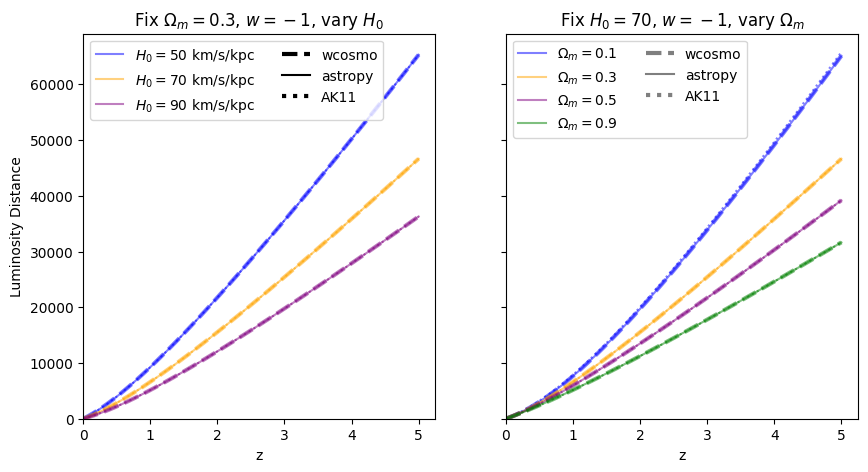

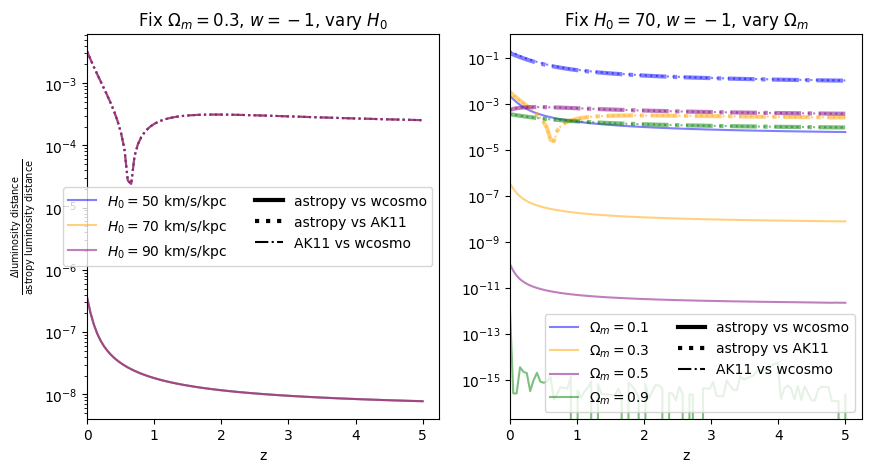

In [15]:
absolute_comparison_ak("luminosity_distance");
fractional_comparison_ak("luminosity_distance");

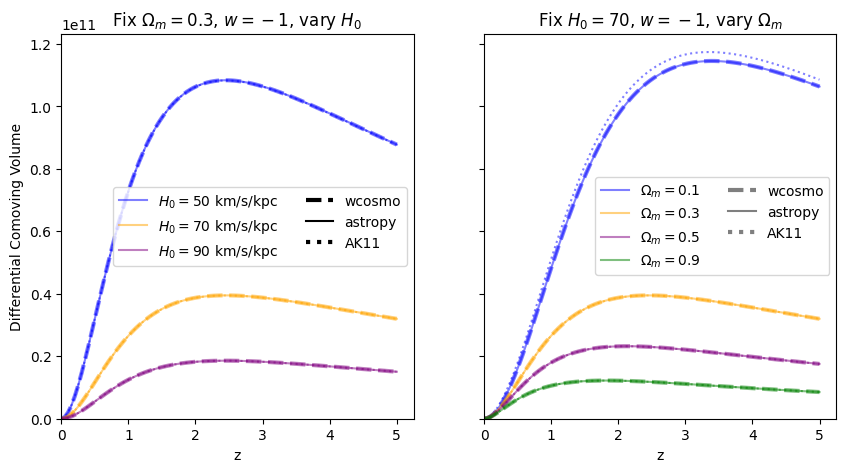

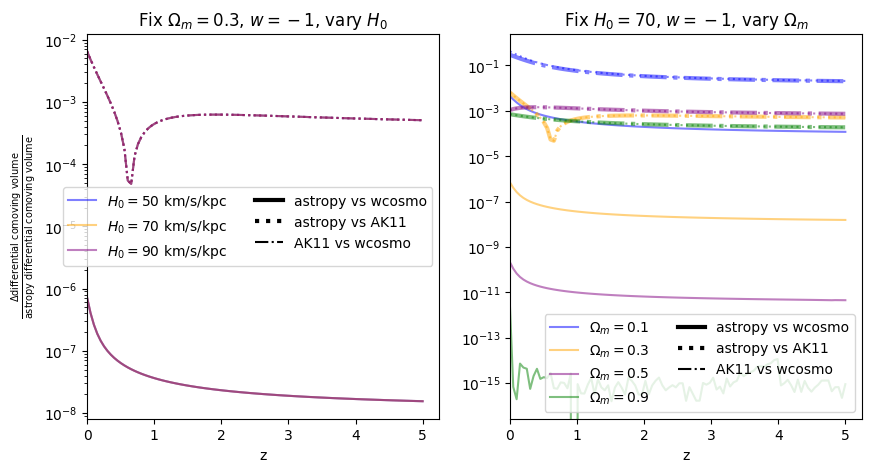

In [16]:
absolute_comparison_ak("differential_comoving_volume");
fractional_comparison_ak("differential_comoving_volume");

Again, there is no dependence on $H_0$. We find that `wcosmo` is orders of magnitude more accurate than AK11 even for $w=-1$, becasue of the inclusion of additional Taylor expansion terms. This is especially noticable at low redshift and high $\Omega_m$. The fractional error between AK11 and `astropy` is comparable to that between AK11 and `wcosmo` (i.e. the dotted and dot-dashed lines overlap) becasue of the high accuracy of `wcosmo`.

## $w\neq -1$
Now we vary $w$. Note we are no longer using the exact form of AK11, but the form used in `wcosmo`, but with the same number of terms as in AK11. We still call this AK11 for simplicity.

### Luminosity distance

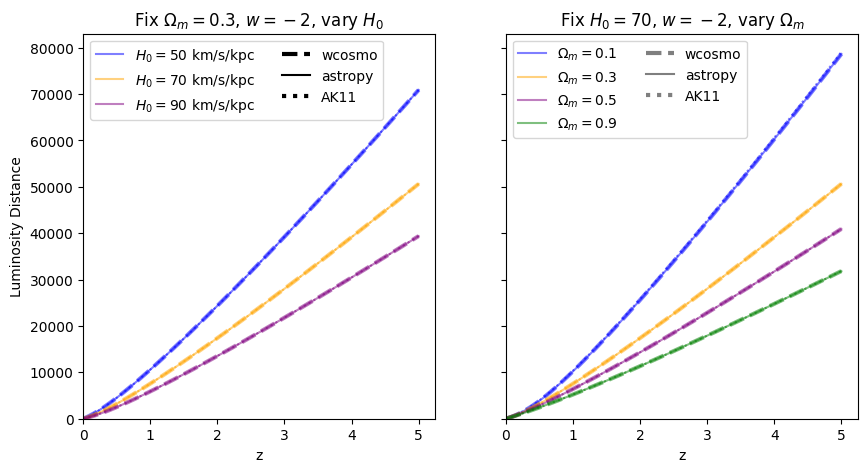

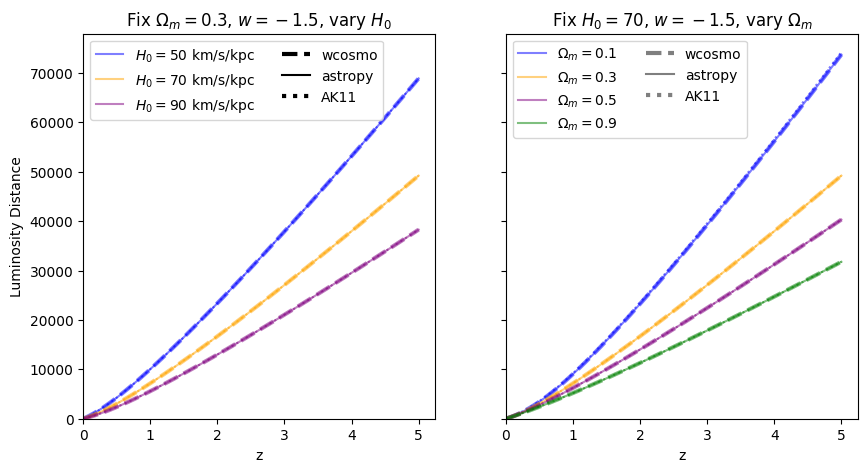

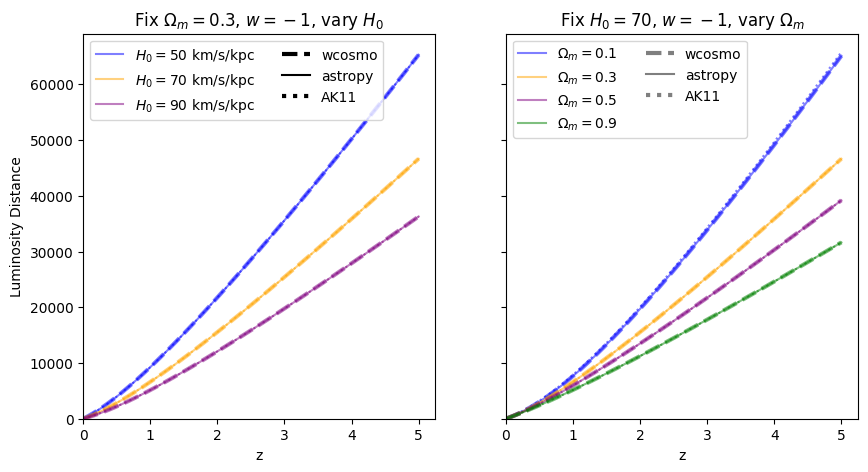

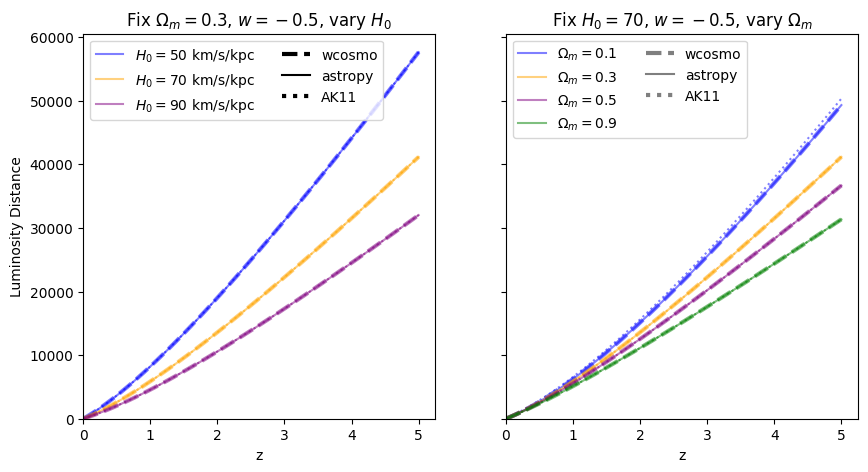

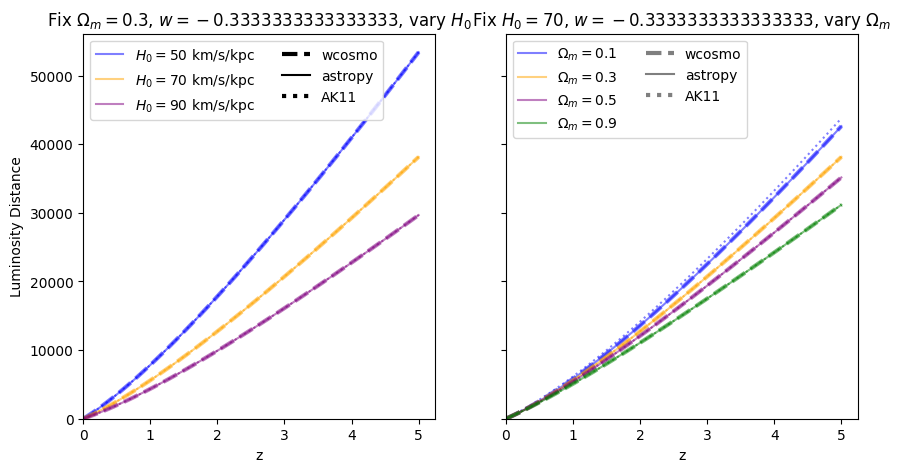

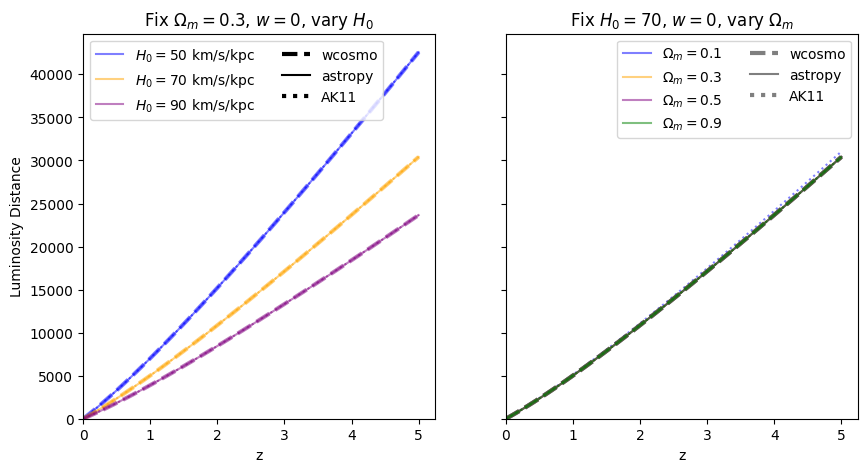

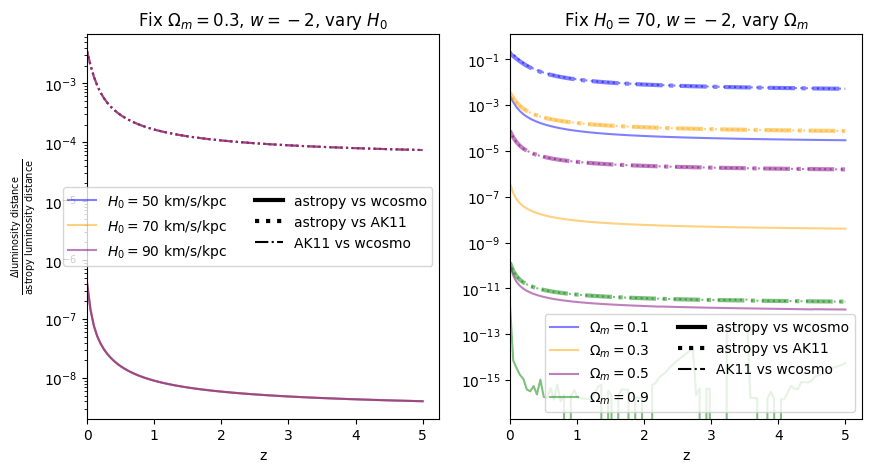

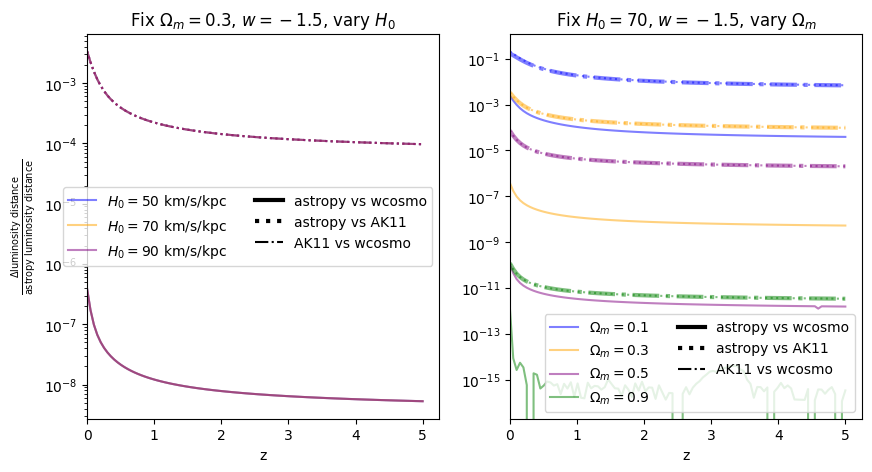

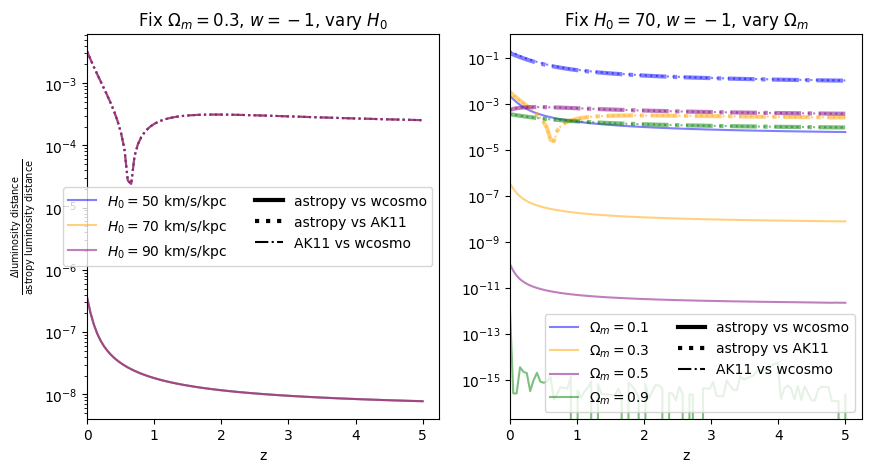

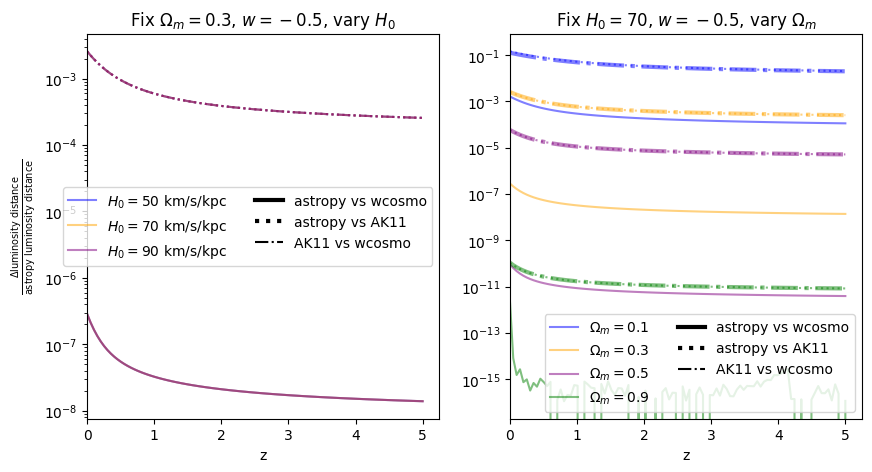

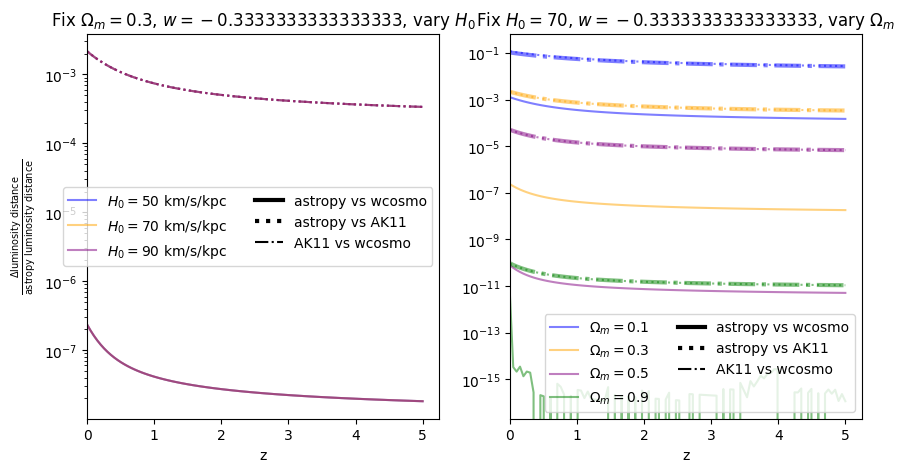

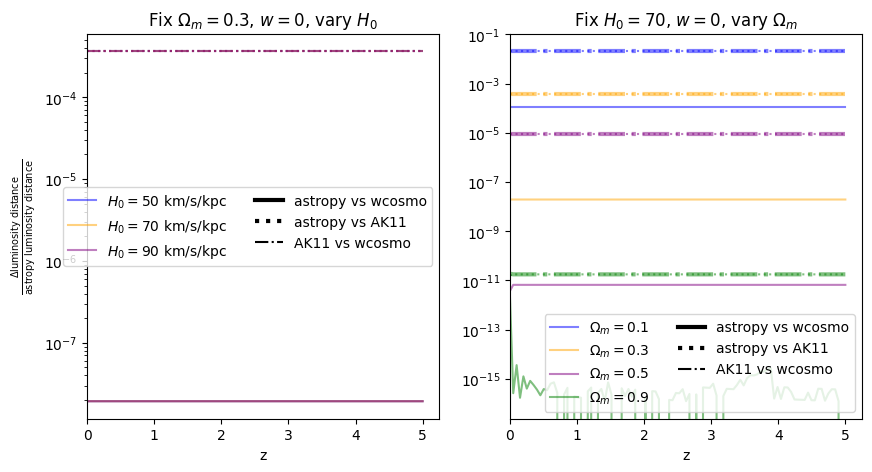

In [17]:
for w in w_vals:
    f=absolute_comparison_ak("luminosity_distance",w=w);
for w in w_vals:
    f=fractional_comparison_ak("luminosity_distance",w=w);

### $\frac{dV_c}{dz}$: differential comoving volume

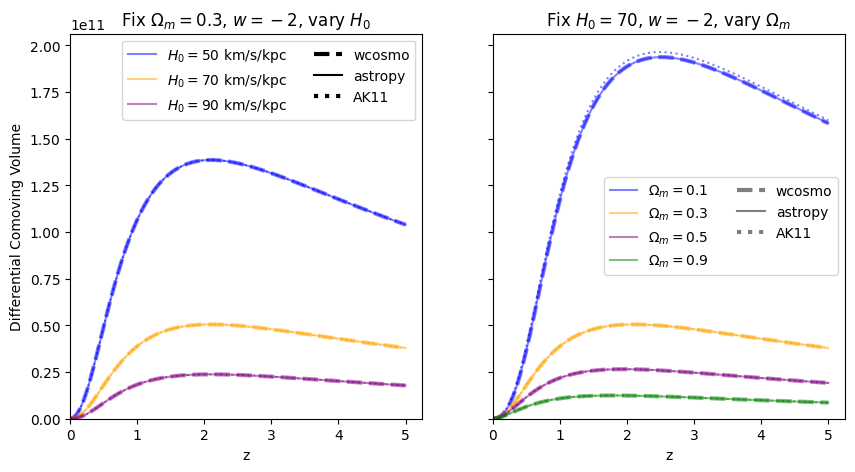

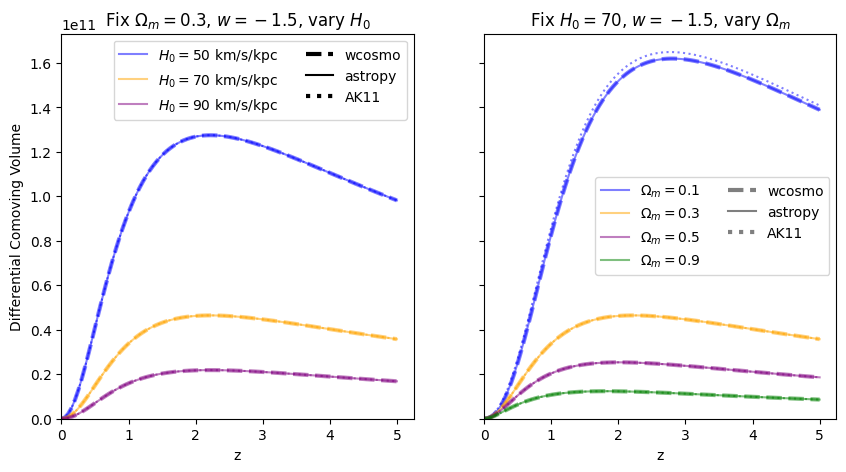

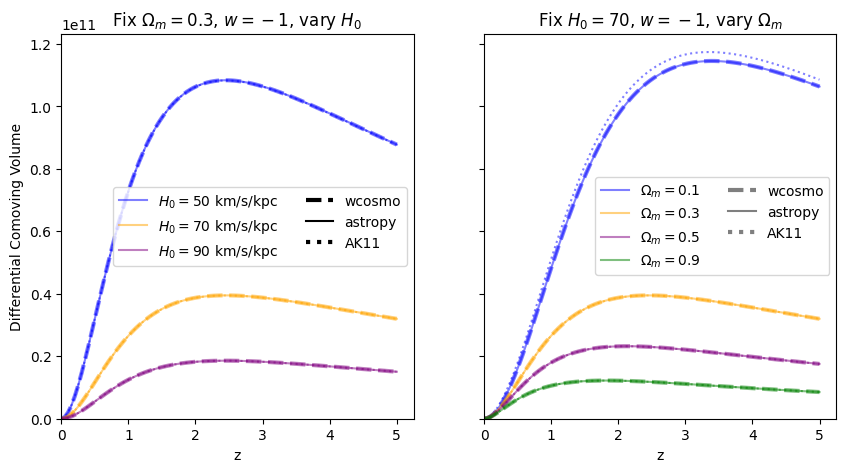

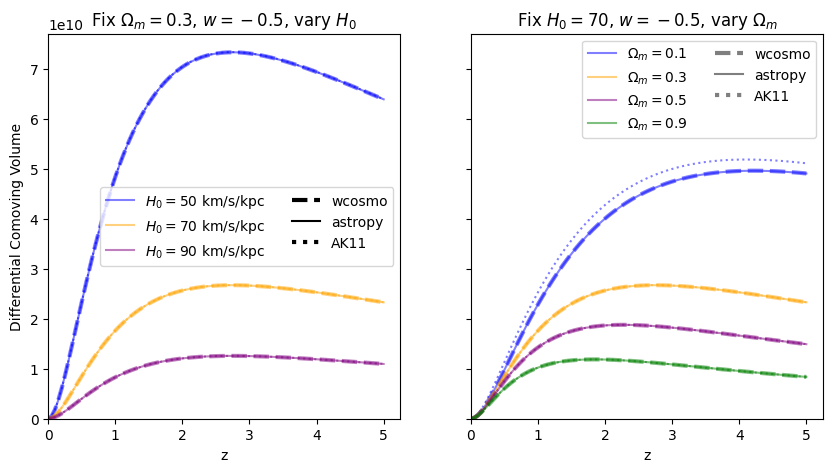

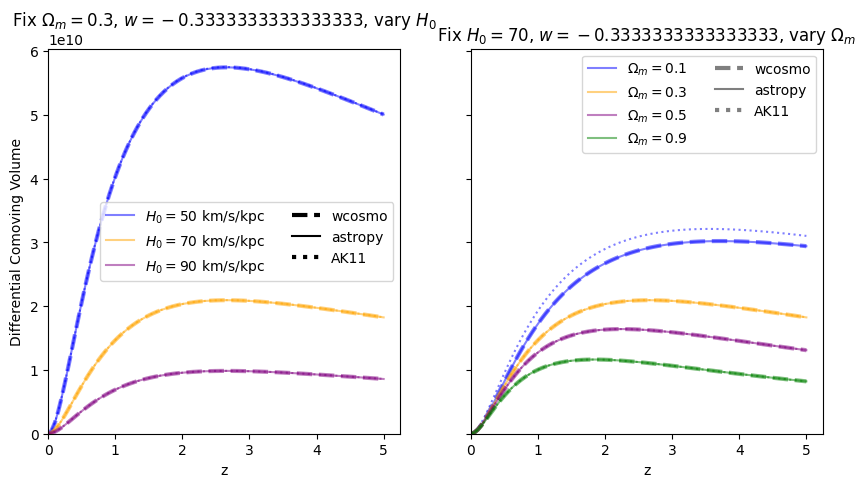

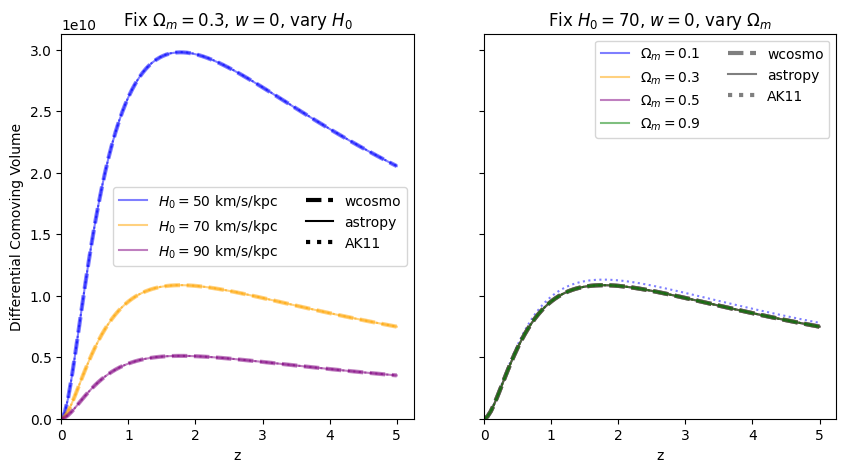

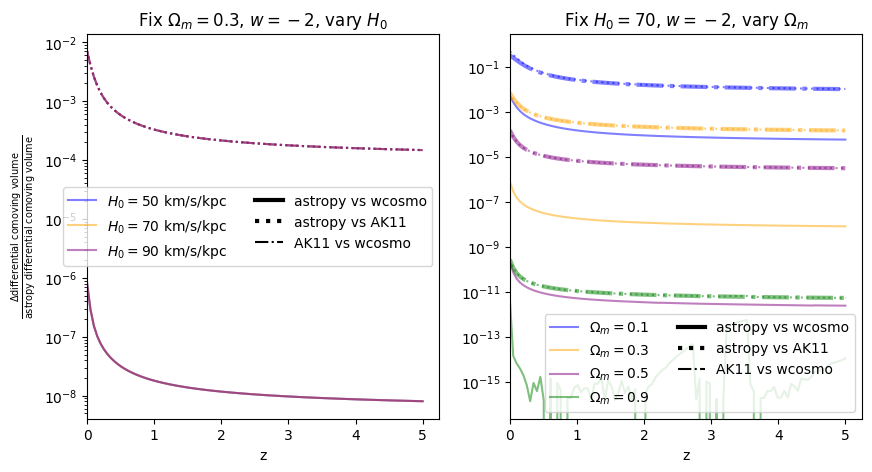

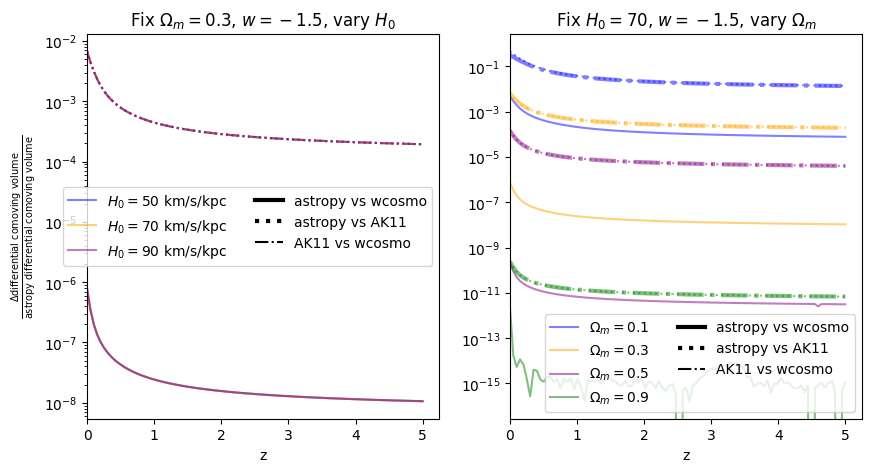

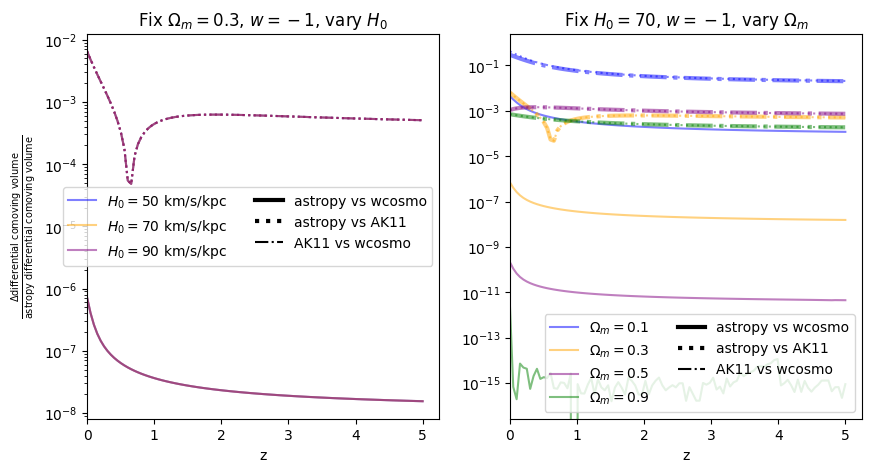

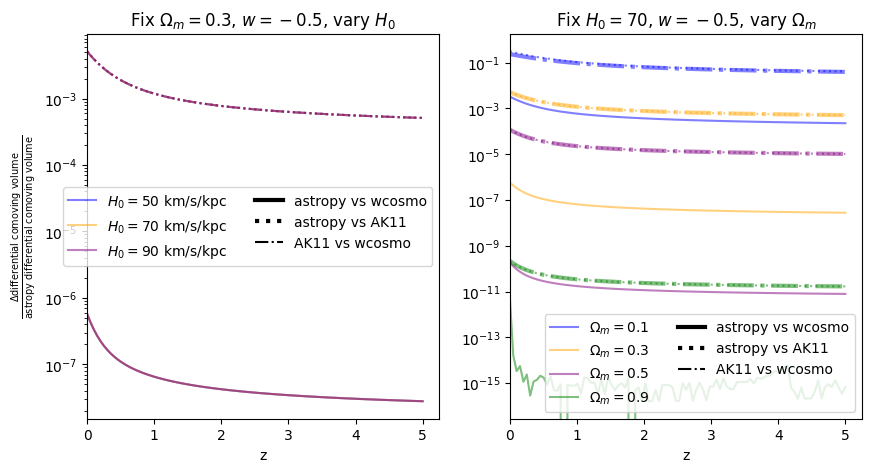

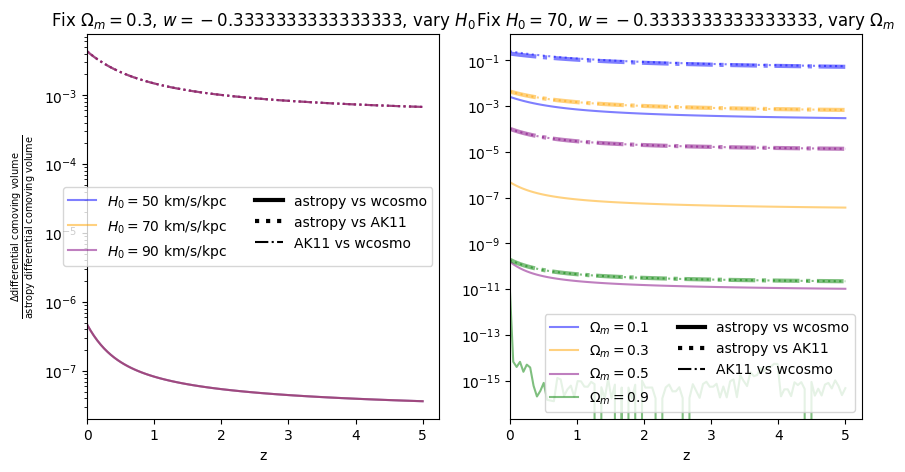

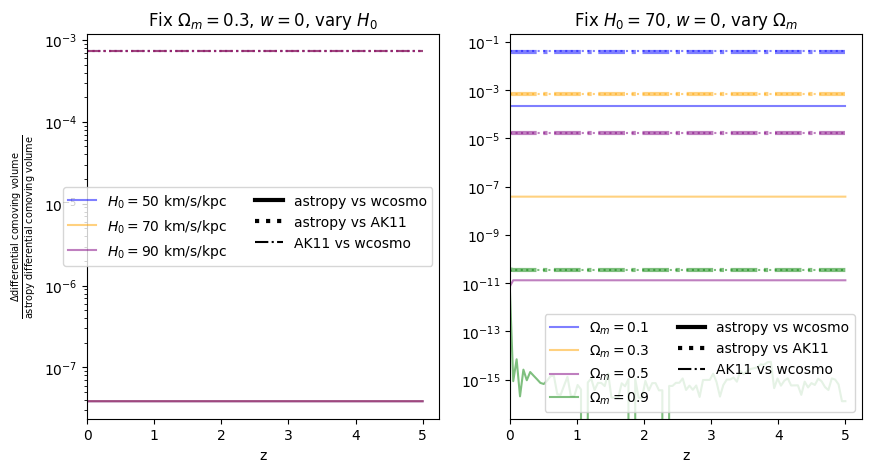

In [18]:
for w in w_vals:
    f=absolute_comparison_ak("differential_comoving_volume",w=w);
for w in w_vals:
    f=fractional_comparison_ak("differential_comoving_volume",w=w);

We find similar results as the $w=-1$ case, confirming that the additional Taylor expansion terms are the reason for the higher accuracy in `wcosmo` vs AK11.